In [58]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torch.utils import data
from torchsummary import summary
    
def load_CIFAR10_data():
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
    train_set = torchvision.datasets.CIFAR10(root='./dataset', train=True,
                                             download=True, transform=transform)
    train_set, validation_set = data.random_split(train_set,
                                                  (int(len(train_set) * 0.9), int(len(train_set) * 0.1)))
    test_set = torchvision.datasets.CIFAR10(root='./dataset', train=False,
                                            download=True, transform=transform)

    train_loader = data.DataLoader(train_set, batch_size=2500,
                                   shuffle=True, num_workers=0)
    validation_loader = data.DataLoader(validation_set, batch_size=2500,
                                        shuffle=True, num_workers=0)
    test_loader = data.DataLoader(test_set, batch_size=2500,
                                  shuffle=True, num_workers=0)
    return train_loader, validation_loader, test_loader, test_set.classes


def load_CIFAR100_data():
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
    train_set = torchvision.datasets.CIFAR100(root='./dataset', train=True,
                                              download=True, transform=transform)
    train_set, validation_set = data.random_split(train_set, (int(len(train_set) * 0.9), int(len(train_set) * 0.1)))
    test_set = torchvision.datasets.CIFAR100(root='./dataset', train=False,
                                             download=True, transform=transform)

    train_loader = data.DataLoader(train_set, batch_size=2500,
                                   shuffle=True, num_workers=0,
                                   pin_memory=True)
    validation_loader = data.DataLoader(validation_set, batch_size=2500,
                                        shuffle=True, num_workers=0,
                                        pin_memory=True)
    test_loader = data.DataLoader(test_set, batch_size=2500,
                                  shuffle=True, num_workers=0,
                                  pin_memory=True)

    return train_loader, validation_loader, test_loader, test_set.classes


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def accuracy_plot(accuracies, TEST):
    plt.plot(range(1, len(accuracies) + 1), accuracies)
    plt.xlabel("epoch")
    plt.ylabel("accuracy\n(%)").set_rotation(0)

    if (TEST):
        plt.legend(["train", "test"])
    else:
        plt.legend(["train", "validation"])


def losses_plot(train_losses, losses, TEST):
    plt.plot(range(1, len(train_losses) + 1), train_losses)
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel("epoch")
    plt.ylabel("loss").set_rotation(0)

    if (TEST):
        plt.legend(["train", "test"])
    else:
        plt.legend(["train", "validation"])


def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    correct = 0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        regularization_loss = 0.0
        for param in model.parameters():
            regularization_loss += torch.norm(param)
        loss = criterion(outputs, y) + LAMBDA * regularization_loss
        loss.backward()
        optimizer.step()
#         outputs = F.softmax(outputs, dim=1)
#         pred = outputs.argmax(dim=1, keepdim=True)
#         correct += pred.eq(y.view_as(pred)).sum().item()
#     train_percentage = round(correct / len(train_loader.dataset) * 100, 2)
#     print(f"Epoch:{epoch} Train Accuracy:{correct}/{len(train_loader.dataset)} ({train_percentage}%)")
    return loss.item()


def validate(model, validation_loader, criterion, device, epoch):
    model.eval()
    vali_loss = 0.0
    correct = 0
    with torch.no_grad():
        for X, y in validation_loader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            vali_loss += criterion(outputs, y).item()
            outputs = F.softmax(outputs, dim=1)
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    vali_loss /= len(validation_loader.dataset)
    vali_percentage = round(correct / len(validation_loader.dataset) * 100, 2)
    print(
        f"Epoch:{epoch} Validation loss: {vali_loss:0.6f}, Validation Accuracy:{correct}/{len(validation_loader.dataset)} ({vali_percentage}%)"
    )
    return vali_percentage, vali_loss


def test(model, test_loader, criterion, device, epoch, classes):
    model.eval()
    class_correct = [0.0 for i in range(len(classes))]
    class_total = [0.0 for i in range(len(classes))]
    
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            test_loss += criterion(outputs, y).item()
            outputs = F.softmax(outputs, dim=1)
            pred = outputs.argmax(dim=1, keepdim=True)
            correct_pred = pred.eq(y.view_as(pred))
            correct += correct_pred.sum().item()
            for i in range(len(y)):
                label = y[i].item()
                class_correct[label] += correct_pred[i].item()
                class_total[label] += 1

    test_percentage = round(correct / len(test_loader.dataset) * 100, 2)
    print(
        f"Epoch:{epoch} Test loss: {test_loss:0.6f}, Test Accuracy:{correct}/{len(test_loader.dataset)} ({test_percentage}%)"
    )
#     for i in range(len(classes)):
#         print(f"{classes[i]} accuaracy: {round(class_correct[i]/class_total[i]*100, 2)}")
#     print("")
    return test_percentage, test_loss


class convLayer(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, pooling_size, padding_size, dropout_rate):
        super(convLayer, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size, padding=padding_size)
        self.pooling_size = pooling_size
        if self.pooling_size:
            self.pool = nn.MaxPool2d(pooling_size)
        self.bm = nn.BatchNorm2d(out_channel)
        self.drop = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.bm(x)
        if self.pooling_size:
            x = self.pool(x)
        x = self.drop(x)
        return x


# https://discuss.pytorch.org/t/flatten-layer-of-pytorch-build-by-sequential-container/5983
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        self.conv1 = convLayer(3, 64, 3, 2, 1, 0.3)
        self.conv2 = convLayer(64, 128, 3, 0, 1, 0.3)
        self.conv3 = convLayer(128, 256, 5, 2, 1, 0.3)
        self.conv4 = convLayer(256, 512, 5, 2, 1, 0.3)
        self.flatten = Flatten()
        self.fc1 = nn.Linear(2048, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 10)
        self.layers = [self.conv1, self.conv2, self.conv3, self.conv4, self.flatten, self.fc1, self.fc2, self.fc3]
        self.activations = [False, False, False, False, False, True, True, True]

    def forward(self, x):
        for layer, activation in zip(self.layers, self.activations):
            if activation:
                x = F.relu(layer(x))
            else:
                x = layer(x)
        return x

class CIFAR100Model(nn.Module):
    def __init__(self, num_classes):
        super(CIFAR10Model, self).__init__()
        self.conv1 = convLayer(3, 64, 3, 2, 1, 0.4)
        self.conv2 = convLayer(64, 128, 3, 0, 1, 0.4)
        self.conv3 = convLayer(128, 256, 5, 2, 1, 0.4)
        self.conv4 = convLayer(256, 512, 5, 2, 1, 0.4)
        self.flatten = Flatten()
        self.fc1 = nn.Linear(2048, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1024)
        self.fc4 = nn.Linear(1024, 100)
        self.layers = [self.conv1, self.conv2, self.conv3, self.conv4, self.flatten, self.fc1, self.fc2, self.fc3, self.fc4]
        self.activations = [False, False, False, False, False, True, True, True, True]

    def forward(self, x):
        for layer, activation in zip(self.layers, self.activations):
            if activation:
                x = F.relu(layer(x))
            else:
                x = layer(x)
        return x
    
def transfer_learning_resnet152(num_classes):
    model = torchvision.models.resnet152(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 1024),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1024, num_classes),
    )
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters())
    return model, criterion, optimizer

In [40]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
train_loader, validation_loader, test_loader, classes = load_CIFAR10_data()
device

Files already downloaded and verified
Files already downloaded and verified


device(type='cuda', index=1)

In [39]:
# # https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# EPOCH = 20
# TEST = True
# LAMBDA = 0.03

# model, criterion, optimizer = transfer_learning_resnet152(10)

# train_accuracies = []
# accuracies = []
# train_losses = []
# losses = []

# for epoch in range(1, EPOCH + 1):
#     acc, loss = train(model, train_loader, optimizer, criterion, device, epoch)
#     train_accuracies.append(acc)
#     train_losses.append(loss)
#     if not TEST:
#         acc, loss = validate(model, validation_loader, criterion, device, epoch)
#         accuracies.append(acc)
#         losses.append(loss)
#     else:
#         acc, loss = test(model, validation_loader, criterion, device, epoch, classes)
#         accuracies.append(acc)
#         losses.append(loss)
# plt.figure(1)
# accuracy_plot(train_accuracies, accuracies, TEST)
# plt.figure(2)
# losses_plot(train_losses, losses, TEST)
# plt.show()

Epoch:1 Test loss: 4.605167, Test Accuracy:491/5000 (9.82%)
Epoch:2 Test loss: 4.600272, Test Accuracy:499/5000 (9.98%)
Epoch:3 Test loss: 4.574796, Test Accuracy:581/5000 (11.62%)
Epoch:4 Test loss: 4.463634, Test Accuracy:821/5000 (16.42%)
Epoch:5 Test loss: 4.457628, Test Accuracy:841/5000 (16.82%)
Epoch:6 Test loss: 4.418896, Test Accuracy:859/5000 (17.18%)
Epoch:7 Test loss: 4.361542, Test Accuracy:1219/5000 (24.38%)
Epoch:8 Test loss: 4.211714, Test Accuracy:1289/5000 (25.78%)
Epoch:9 Test loss: 3.948653, Test Accuracy:1354/5000 (27.08%)
Epoch:10 Test loss: 3.722529, Test Accuracy:1656/5000 (33.12%)
Epoch:11 Test loss: 3.344642, Test Accuracy:2146/5000 (42.92%)
Epoch:12 Test loss: 3.312738, Test Accuracy:2140/5000 (42.8%)
Epoch:13 Test loss: 3.059008, Test Accuracy:2540/5000 (50.8%)
Epoch:14 Test loss: 2.527184, Test Accuracy:2846/5000 (56.92%)
Epoch:15 Test loss: 2.402784, Test Accuracy:2949/5000 (58.98%)
Epoch:16 Test loss: 2.434732, Test Accuracy:2961/5000 (59.22%)
Epoch:17 Te

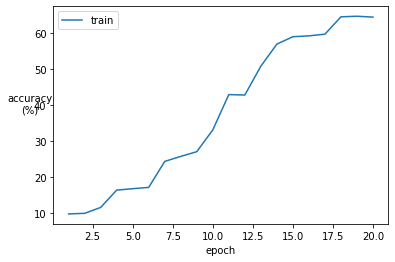

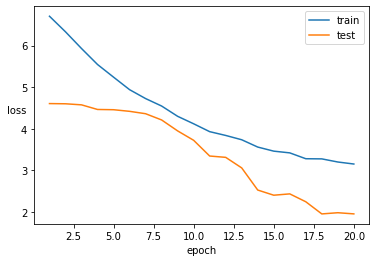

In [46]:
EPOCH = 40
TEST = True
LAMBDA = 0.03

model = CIFAR10Model()
model.to(device)

summary(model, (3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

accuracies = []
train_losses = []
losses = []

for epoch in range(1, EPOCH + 1):
    loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_losses.append(loss)
    if not TEST:
        acc, loss = validate(model, validation_loader, criterion, device, epoch)
        accuracies.append(acc)
        losses.append(loss)
    else:
        acc, loss = test(model, validation_loader, criterion, device, epoch, classes)
        accuracies.append(acc)
        losses.append(loss)
plt.figure(1)
accuracy_plot(train_accuracies, accuracies, TEST)
plt.figure(2)
losses_plot(train_losses, losses, TEST)
plt.show()

In [48]:
for epoch in range(1, EPOCH + 41):
    loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_losses.append(loss)
    if not TEST:
        acc,loss = validate(model, validation_loader, criterion, device, epoch)
        accuracies.append(acc)
        losses.append(loss)
    else:
        acc, loss = test(model, validation_loader, criterion, device, epoch, classes)
        accuracies.append(acc)
        losses.append(loss)
plt.figure(1)
accuracy_plot(train_accuracies, accuracies, TEST)
plt.figure(2)
losses_plot(train_losses, losses, TEST)
plt.show()

Epoch:1 Test loss: 1.846104, Test Accuracy:3327/5000 (66.54%)
Epoch:2 Test loss: 1.895761, Test Accuracy:3285/5000 (65.7%)
Epoch:3 Test loss: 1.889189, Test Accuracy:3295/5000 (65.9%)
Epoch:4 Test loss: 1.957309, Test Accuracy:3265/5000 (65.3%)
Epoch:5 Test loss: 1.890020, Test Accuracy:3301/5000 (66.02%)
Epoch:6 Test loss: 1.967824, Test Accuracy:3292/5000 (65.84%)
Epoch:7 Test loss: 2.198511, Test Accuracy:3208/5000 (64.16%)
Epoch:8 Test loss: 1.741412, Test Accuracy:3656/5000 (73.12%)
Epoch:9 Test loss: 1.528989, Test Accuracy:3731/5000 (74.62%)
Epoch:10 Test loss: 1.537842, Test Accuracy:3728/5000 (74.56%)
Epoch:11 Test loss: 1.458150, Test Accuracy:3789/5000 (75.78%)
Epoch:12 Test loss: 1.502273, Test Accuracy:3779/5000 (75.58%)
Epoch:13 Test loss: 1.520694, Test Accuracy:3774/5000 (75.48%)
Epoch:14 Test loss: 1.459546, Test Accuracy:3743/5000 (74.86%)
Epoch:15 Test loss: 1.446465, Test Accuracy:3813/5000 (76.26%)
Epoch:16 Test loss: 1.509598, Test Accuracy:3757/5000 (75.14%)
Epoc

KeyboardInterrupt: 

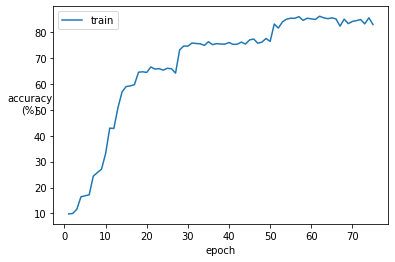

In [60]:
accuracy_plot(accuracies, TEST)
plt.savefig("accuracies.png")

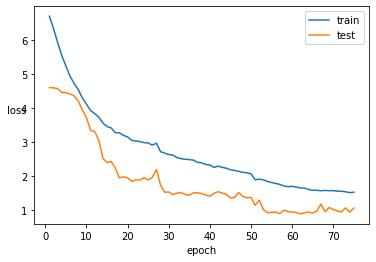

In [61]:
losses_plot(train_losses, losses, TEST)
plt.savefig("losses.png")